In [1]:
# code from https://github.com/pawni/BayesByHypernet_Pytorch.git
# modified

import numpy as np
import time
import warnings
import pandas as pd
import torch

from Experiments import get_setup

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


setup_ = get_setup('foong')
setup=setup_.Setup(device) 


x_train, y_train=setup.train_data()

data_x=x_train.cpu().numpy()
data_y=y_train.cpu().numpy()
x_test, y_test=setup.test_data()

num_samples=x_train.shape[0]

rng = np.random.RandomState(1)

linspace = torch.linspace(-2., 2., 500)


"""
num_samples = 20
#num_samples = 10000

data_x = rng.uniform(low=-4, high=4, size=(num_samples,))
data_y = data_x**3 + rng.normal(loc=0, scale=9, size=(num_samples,))

linspace = np.linspace(-6, 6, num=500)
"""


'\nnum_samples = 20\n#num_samples = 10000\n\ndata_x = rng.uniform(low=-4, high=4, size=(num_samples,))\ndata_y = data_x**3 + rng.normal(loc=0, scale=9, size=(num_samples,))\n\nlinspace = np.linspace(-6, 6, num=500)\n'

In [295]:
import math
import numpy as np

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.distributions as dist


class HypernetWeight(nn.Module):
    def __init__(self, shape, units=[16, 32, 64], bias=True,
                 noise_shape=1, activation=nn.LeakyReLU(0.1)):
        super(HypernetWeight, self).__init__()
        self.shape = shape
        self.noise_shape = noise_shape

        layers = []
        in_features = noise_shape
        for out_features in units:
            layers.append(nn.Linear(in_features, out_features, bias=bias))
            layers.append(activation)
            in_features = out_features

        layers.append(nn.Linear(in_features, np.prod(shape), bias=bias))

        self.net = nn.Sequential(*layers)

    def forward(self, x=None, num_samples=1):
        if x is None:
            x = torch.randn((num_samples, self.noise_shape))
        return self.net(x).reshape((x.shape[0], *self.shape))


class ToyNN(nn.Module):
    def __init__(self, units=[16, 32, 64]):
        super(ToyNN, self).__init__()
        self.layer1_w = HypernetWeight((50, 1), units=units)
        self.layer1_b = HypernetWeight((50, ), units=units)
        self.layer2_w = HypernetWeight((1, 50), units=units)
        self.layer2_b = HypernetWeight((1, ), units=units)

    def forward(self, x):
        w1 = self.layer1_w().squeeze(0)
        b1 = self.layer1_b().squeeze(0)

        w2 = self.layer2_w().squeeze(0)
        b2 = self.layer2_b().squeeze(0)
        activation=nn.Tanh()
        x = F.linear(x, w1, b1)
        x = activation(x)
        x = F.linear(x, w2, b2)

        return x

    def sample(self, num_samples=5):
        l1_w_samples = self.layer1_w(num_samples=num_samples).view((num_samples, -1))
        l1_b_samples = self.layer1_b(num_samples=num_samples).view((num_samples, -1))
        l2_w_samples = self.layer2_w(num_samples=num_samples).view((num_samples, -1))
        l2_b_samples = self.layer2_b(num_samples=num_samples).view((num_samples, -1))

        gen_weights = torch.cat([l1_w_samples, l1_b_samples, l2_w_samples, l2_b_samples], 1)

        return gen_weights

    def kl(self, num_samples=5, full_kernel=True):

        gen_weights = self.sample(num_samples=num_samples)
        gen_weights = gen_weights.transpose(1, 0)
        prior_samples = torch.randn_like(gen_weights)

        eye = torch.eye(num_samples, device=gen_weights.device)
        wp_distances = (prior_samples.unsqueeze(2) - gen_weights.unsqueeze(1)) ** 2
        # [weights, samples, samples]

        ww_distances = (gen_weights.unsqueeze(2) - gen_weights.unsqueeze(1)) ** 2

        if full_kernel:
            wp_distances = torch.sqrt(torch.sum(wp_distances, 0) + 1e-8)
            wp_dist = torch.min(wp_distances, 0)[0]

            ww_distances = torch.sqrt(
                torch.sum(ww_distances, 0) + 1e-8) + eye * 1e10
            ww_dist = torch.min(ww_distances, 0)[0]

            # mean over samples
            kl = torch.mean(torch.log(wp_dist / (ww_dist + 1e-8) + 1e-8))
            kl *= gen_weights.shape[0]
            kl += np.log(float(num_samples) / (num_samples - 1))
        else:
            wp_distances = torch.sqrt(wp_distances + 1e-8)
            wp_dist = torch.min(wp_distances, 1)[0]

            ww_distances = (torch.sqrt(ww_distances + 1e-8)
                            + (eye.unsqueeze(0) * 1e10))
            ww_dist = torch.min(ww_distances, 1)[0]

            # sum over weights, mean over samples
            kl = torch.sum(torch.mean(
                torch.log(wp_dist / (ww_dist + 1e-8) + 1e-8)
                + np.log(float(num_samples) / (num_samples - 1)), 1))

        return kl

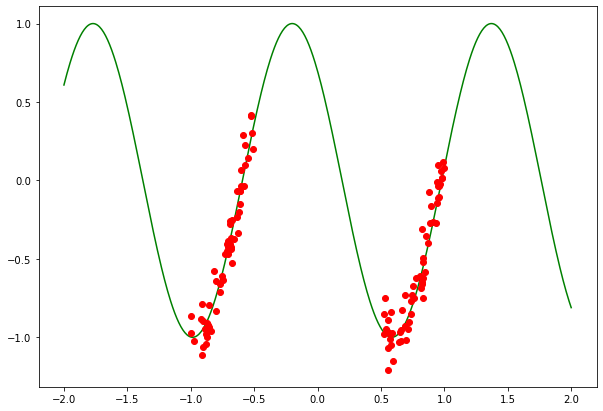

In [296]:
# plot toy data
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
plt.plot(linspace, torch.cos(4.0*(linspace+0.2)),color='green')
plt.plot(data_x, data_y, 'ro')
plt.show()

In [297]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
from tqdm import trange
import torch.distributions as dist

def seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)

In [298]:
seed(42)

In [306]:
model = ToyNN()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, eps=1e-5)

crit = lambda x, y: torch.sum(-1 * dist.Normal(0., 9.).log_prob(x - y))

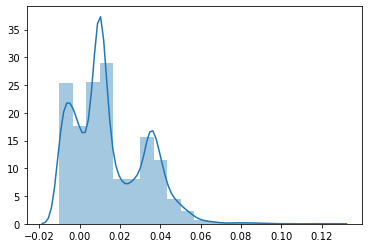

0.014475607313215733 - 0.01757100038230419


In [307]:
samples_before = model.sample(10000).detach().numpy()
sns.distplot(samples_before[:, 0], bins=20)
plt.show()
print('{} - {}'.format(samples_before[:, 0].mean(), samples_before[:, 0].std()))

In [308]:
cols = ['x', 'y', 'mode', 'mc']


batch_x = torch.from_numpy(data_x.astype(np.float32).reshape(num_samples, 1))
batch_y = torch.from_numpy(data_y.astype(np.float32).reshape(num_samples, 1))

with trange(2000) as pbar:
    for i in pbar:
        optimizer.zero_grad()
        cur_anneal = 1.#np.clip(1000. / (i + 1) - 1., 0., 1.)
        preds = model(batch_x)
        mse = crit(preds, batch_y)
        kl = model.kl()

        loss = mse + cur_anneal * kl

        loss.backward()
        optimizer.step()
        
        pbar.set_postfix(loss=loss.item(), mse=mse.item(), kl=kl.item(),anneal=cur_anneal)

 99%|█████████▉| 1985/2000 [00:13<00:00, 154.93it/s, anneal=1, kl=-126, loss=248, mse=374] 

KeyboardInterrupt: 

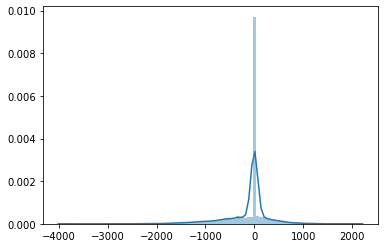

-120.03852844238281 - 439.39837646484375


In [309]:
samples_after = model.sample(10000).detach().numpy()
w_idx = 0
sns.distplot(samples_after[:, w_idx], bins=100)
plt.show()
print('{} - {}'.format(samples_after[:, w_idx].mean(), samples_after[:, w_idx].std()))

In [310]:
mcsteps = 100

prediction_df = pd.DataFrame(columns=cols)
all_preds = np.zeros(len(linspace))
batch_x = torch.from_numpy(linspace[:, np.newaxis].numpy().astype(np.float32))
for mc in range(mcsteps):
    with torch.no_grad():
        predictions = model(batch_x).squeeze()
    all_preds += predictions.numpy() / mcsteps
    new_df = pd.DataFrame(columns=cols, data=list(zip(
            linspace.numpy(), predictions.numpy(), ['implicit']*len(linspace), [mc]*len(linspace))))

    prediction_df = pd.concat([prediction_df, new_df])


In [311]:
print(np.sqrt(np.mean((all_preds - np.cos(4.0*(linspace.numpy()+0.2)))**2)))

0.8868049943996236


torch.Size([500])
(500,)


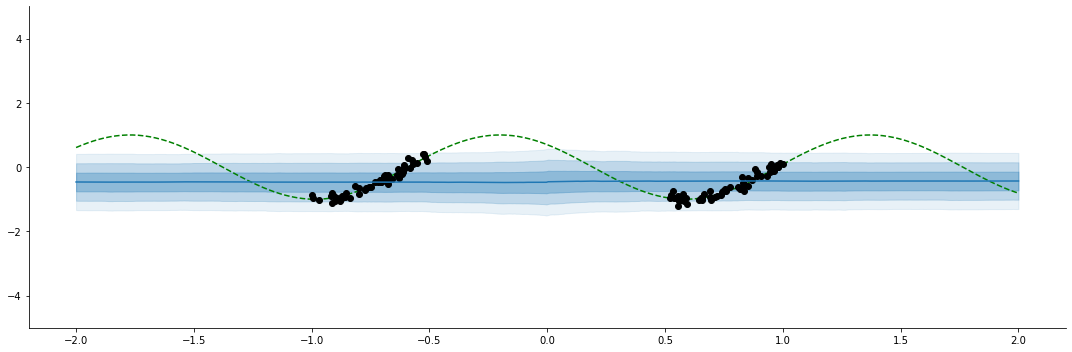

In [312]:
plt.figure(figsize=(15, 5))

plt.plot(linspace, torch.cos(4.0*(linspace+0.2)), '--', color='green',label='Real function')
plt.plot(data_x, data_y, 'o', color='black', label='Samples')

colour = sns.color_palette(n_colors=9)[0]

groups = prediction_df.groupby(['x'])
mean_pred = groups.mean().values[:, 0]
std_pred = groups.std().values[:, 0]
print(linspace.shape)
print(mean_pred.shape)
plt.plot(linspace, mean_pred, color=colour)

plt.fill_between(linspace,
                 mean_pred + 1 * std_pred,
                 mean_pred - 1 * std_pred,
                 color=colour, alpha=0.3)
plt.fill_between(linspace,
                 mean_pred + 2 * std_pred,
                 mean_pred - 2 * std_pred,
                 color=colour, alpha=0.2)
plt.fill_between(linspace,
                 mean_pred + 3 * std_pred,
                 mean_pred - 3 * std_pred,
                 color=colour, alpha=0.1)

plt.ylim(-5, 5)
sns.despine()
plt.tight_layout()
plt.show()

tensor([   0.,    1.,    2.,  ...,  998.,  999., 1000.])


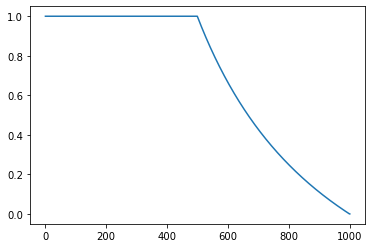

In [225]:
steps=torch.linspace(0,1000,1001)
print(steps)
plt.plot(steps,np.clip(1000. / (steps + 1.) - 1., 0., 1.))

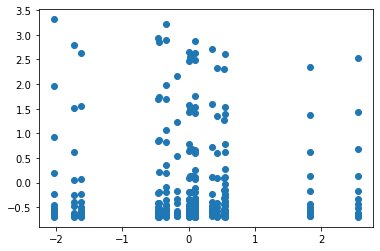

In [23]:
%matplotlib inline 
import matplotlib.pyplot as plt
setup_ = get_setup('yacht')
setup=setup_.Setup(device) 


x_train, y_train=setup.train_data()
x_train[:,0].shape
plt.scatter(x_train[:,3].cpu(), y_train.cpu())